In [3]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow
import re
regex = re.compile(r"perturbation_experiment_([^_]+)_level")



levels = ["0", "0.5", "1.0"]
data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
base_fname = file_pattern.format(gene = "JUND", level = "1.0")
base_embeddings = np.load(f"{base_fname}.embeddings.npy")
adata = anndata.read_h5ad(f"{base_fname}.h5ad")
base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
with open(f"crohn_classifier2.xgboost.pkl", "rb") as f:
    xgb_model = pickle.load(f)
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir).glob("*.npy"))])
base_df.sample(5)

,tissue,cell_type,sex,development_stage,disease
cell_id,,,,,
N15_Epi_A-CGTTTAACCCTTGC,right colon,epithelial cell,male,human adult stage,normal
N105446_L-TTCCTTCGTAGTATAG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease
N10_Epi_A-AGTGTTCTATGGTC,right colon,goblet cell,female,human adult stage,normal
I114902_N-CACAGGCCACAAGCCC,colon,enterocyte,male,fourth decade human stage,Crohn disease
N178961_L-AACAAGAAGCACGTCC,lamina propria of mucosa of colon,enterocyte,male,seventh decade human stage,Crohn disease


In [4]:

base_umap = umap.UMAP().fit(base_embeddings)

In [5]:
umap_control = base_umap.transform(base_embeddings)

In [7]:
base_df[["umap_x", "umap_y"]] = umap_control
base_df

,tissue,cell_type,sex,development_stage,disease,umap_x,umap_y
cell_id,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.755900,1.716173
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.869006,1.650303
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.888717,1.644838
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,5.758903,-0.251103
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,5.779029,-0.150266
...,...,...,...,...,...,...,...
N130084_L-GTGGTTACAGTTCCAA,lamina propria of mucosa of colon,brush cell,female,fifth decade human stage,Crohn disease,8.022009,1.247482
N130084_L-TATCCTATCGTTCATT,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,-0.715075,5.863628
N130084_L-TCATCCGGTATGATCC,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,0.248024,5.242847


In [10]:
el = {0: "KO", 5.0 : "OE"}
df = base_df.copy()
for gene in tqdm(genes):
    for expression_level in tqdm([0, 5.0]):
        embedding_filename =  file_pattern.format(gene = gene, level = expression_level) + ".embeddings.npy"
        emb = np.load(embedding_filename)
        level = el[expression_level]
        df[[f"umap_x_{level}_{gene}", f"umap_y_{level}_{gene}"]] = base_umap.transform(emb)

df

100%|██████████| 7/7 [07:44<00:00, 66.35s/it]


,tissue,cell_type,sex,development_stage,disease,umap_x,umap_y,umap_x_KO_IFI6,umap_y_KO_IFI6,umap_x_OE_IFI6,...,umap_x_OE_RAC1,umap_y_OE_RAC1,umap_x_KO_NOD2,umap_y_KO_NOD2,umap_x_OE_NOD2,umap_y_OE_NOD2,umap_x_KO_IL23R,umap_y_KO_IL23R,umap_x_OE_IL23R,umap_y_OE_IL23R
cell_id,,,,,,,,,,,,,,,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.755900,1.716173,4.850476,1.693097,4.866830,...,4.885270,1.675651,4.895808,1.721588,4.854322,1.695852,4.886613,1.707141,4.872137,1.692917
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.869006,1.650303,4.887463,1.658094,4.903378,...,4.876246,1.673006,4.905046,1.665642,4.908101,1.668801,4.905604,1.678309,4.899949,1.671030
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.888717,1.644838,4.901249,1.649475,4.933224,...,4.917584,1.650105,4.924728,1.654236,4.891357,1.653476,4.870160,1.684380,4.908098,1.651135
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,5.758903,-0.251103,5.706981,-0.296228,5.909128,...,5.754697,-0.278529,5.831416,-0.327149,5.862016,-0.352367,5.757944,-0.301451,5.738328,-0.281019
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,5.779029,-0.150266,5.790055,-0.162087,5.776738,...,5.748878,-0.143236,5.755873,-0.161097,5.782208,-0.180451,5.810255,-0.144348,5.761655,-0.157963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N130084_L-GTGGTTACAGTTCCAA,lamina propria of mucosa of colon,brush cell,female,fifth decade human stage,Crohn disease,8.022009,1.247482,8.051418,1.332385,8.043179,...,8.017582,1.260105,7.999660,1.272694,8.014332,1.236940,8.029325,1.285638,8.004009,1.273266
N130084_L-TATCCTATCGTTCATT,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,-0.715075,5.863628,-0.452189,5.883524,-0.631921,...,-1.244065,5.009917,-0.471454,5.984047,-0.770447,5.651961,-0.838653,5.276043,-0.514838,6.195966
N130084_L-TCATCCGGTATGATCC,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,0.248024,5.242847,0.058448,5.525115,0.138266,...,0.113237,5.981954,0.069104,5.268886,0.196595,5.413706,0.129108,5.467382,0.160889,4.799021


In [11]:
df.to_csv("/data/umap_of_genes_perturbation_in_crohn_colon_epithelial_tissues.csv.zip", compression="zip")

In [13]:
!ls -lh /data

total 15M
drwxr-xr-x 2 nobody nogroup 6.0K May  2 11:35 gene_perturbation_colon_epithelial_scGPT_with_binning_1
drwxr-xr-x 2 nobody nogroup 6.0K May  2 08:12 github_copilot
drwxr-xr-x 3 nobody nogroup 6.0K May  1 08:12 scgpt_perturbation_colon_epithel
drwxr-xr-x 3 nobody nogroup 6.0K May  1 12:06 scgpt_perturbation_colon_epithel2
-rw-r--r-- 1 root   root     15M May  3 13:31 umap_of_genes_perturbation_in_crohn_colon_epithelial_tissues.csv.zip


<Axes: xlabel='umap_x', ylabel='umap_y'>

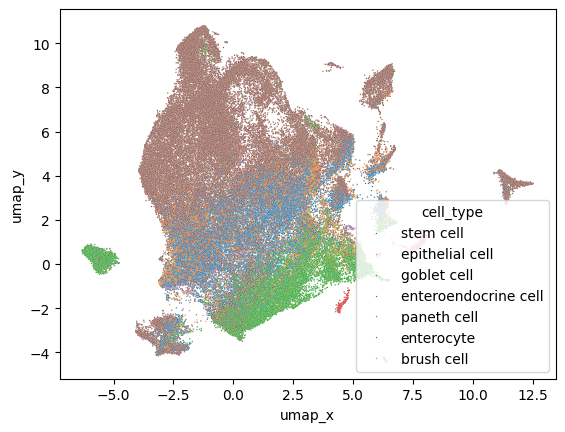

In [16]:
sns.scatterplot(data=df, x="umap_x", y="umap_y", hue="cell_type", s=1)

<Axes: xlabel='umap_x', ylabel='umap_y'>

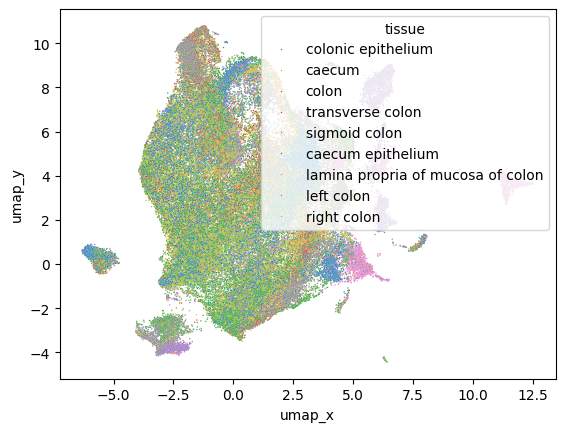

In [17]:
sns.scatterplot(data=df, x="umap_x", y="umap_y", hue="tissue", s=1)